In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from pycaret.time_series import TSForecastingExperiment

### Load and preprocess data

In [2]:
def loadAndPreprocessData(filePath, targetColumns):
    data = pd.read_csv(filePath)
    data = data[data['Location'] == 'Phoenix']
    data['Date_Time'] = pd.to_datetime(data['Date_Time'])
    data = data.sort_values(by='Date_Time').reset_index(drop=True)
    
    data['Date'] = data['Date_Time'].dt.date
    dailyData = data.groupby('Date').agg({
        col: 'mean' for col in targetColumns
    }).reset_index()

    dailyData['Date'] = pd.to_datetime(dailyData['Date'])
    dailyData = dailyData.set_index('Date').asfreq('D')
    dailyData = dailyData.interpolate(method='time') 
    
    return dailyData

### Splitting the data into training & testing 

In [3]:
def splitData(data, targetColumn, splitRatio=0.8):
    splitIndex = int(len(data) * splitRatio)
    trainData = data.iloc[:splitIndex][[targetColumn]].copy()
    testData = data.iloc[splitIndex:][[targetColumn]].copy()
    return trainData, testData

### Train Forecasting Models

In [4]:
def setupPycaretExperiment(trainData, targetColumn):
    exp = TSForecastingExperiment()
    exp.setup(
        data=trainData,
        target=targetColumn,
        numeric_imputation_target='mean',
        session_id=123
    )
    return exp

### Printing evaluation metrics

### Metrics Calculation

In [5]:
def calculateMetrics(actual, predicted, n, k):
  
    r2 = r2_score(actual, predicted)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    vaf = 1 - (np.var(actual - predicted) / np.var(actual))
    return {
        'R²': r2,
        'Adjusted R²': adjusted_r2,
        'VAF': vaf
    }

def plotStyledMetricsTable(metricsDf, title):

    metricsDf = metricsDf.round(4) 
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')

    row_colors = ['white'] * len(metricsDf)
    if 'Mean' in metricsDf['Model'].values:
        mean_index = metricsDf[metricsDf['Model'] == 'Mean'].index[0]
        row_colors[mean_index] = '#FFD700'  

    table = ax.table(
        cellText=metricsDf.values,
        colLabels=metricsDf.columns,
        loc='center',
        cellLoc='center',
        rowColours=row_colors,
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(metricsDf.columns))))
    plt.title(title, fontsize=12, pad=10)
    plt.show()


### Plotting actual vs forecasted values

In [6]:
def trainAndEvaluateModels(
    exp, 
    forecastHorizon, 
    testData, 
    label, 
    minValue, 
    maxValue, 
    lineSpace=0, 
    xlim=None, 
    ylim=None
):
    models = ['arima', 'naive', 'theta', 'grand_means', 'auto_arima']
    forecasts = {}
    metricsList = []
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(
        testData.index, 
        testData[label], 
        marker='o', 
        linestyle='-', 
        label=f'Actual {label}', 
        linewidth=2, 
        alpha=0.8
    )

    lineStyles = ['-', '--', '-.', ':']
    colors = ['blue', 'orange', 'green', 'purple', 'brown']
    
    for i, model in enumerate(models):
        print(f"Training {model}...")
        trainedModel = exp.create_model(model)
        forecast = exp.predict_model(trainedModel, fh=forecastHorizon)
        
        spacedForecast = forecast + (i * lineSpace)
        forecasts[model] = spacedForecast
        
        plt.plot(
            testData.index, 
            spacedForecast, 
            marker='o', 
            linestyle=lineStyles[i % len(lineStyles)], 
            label=f'{model.upper()} Forecast (Offset by {i * lineSpace:.2f})', 
            linewidth=1.5, 
            alpha=0.9, 
            color=colors[i % len(colors)]
        )

        metrics = calculateMetrics(
            actual=testData[label].values,
            predicted=forecast.values,
            n=len(testData),
            k=1 
        )
        metrics['Model'] = model.upper()
        metricsList.append(metrics)

    plt.axhline(
        y=minValue, 
        color='red', 
        linestyle='--', 
        linewidth=1.5, 
        label=f'Min {label}: {minValue:.2f}'
    )
    plt.axhline(
        y=maxValue, 
        color='green', 
        linestyle='--', 
        linewidth=1.5, 
        label=f'Max {label}: {maxValue:.2f}'
    )

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.title(f'Actual vs Forecasted {label} for All Models')
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    metricsDf = pd.DataFrame(metricsList)
    
    meanRow = metricsDf.mean(numeric_only=True).to_dict()
    meanRow['Model'] = 'Mean'
    metricsDf = metricsDf.append(meanRow, ignore_index=True)

    plotStyledMetricsTable(metricsDf, title=f'Metrics Summary for {label}')

    return forecasts, metricsDf


In [7]:
def runForecastPipeline(
    filePath, 
    targetColumn, 
    forecastHorizonRatio=0.2, 
    minValue=None, 
    maxValue=None, 
    lineSpace=0, 
    xlim=None, 
    ylim=None
):
    data = loadAndPreprocessData(filePath, targetColumns=[targetColumn])
    trainData, testData = splitData(data, targetColumn, splitRatio=1 - forecastHorizonRatio)
    forecastHorizon = list(range(1, len(testData) + 1))
    
    exp = setupPycaretExperiment(trainData, targetColumn)
    forecasts = trainAndEvaluateModels(
        exp, 
        forecastHorizon, 
        testData, 
        targetColumn, 
        minValue, 
        maxValue, 
        lineSpace=lineSpace, 
        xlim=xlim, 
        ylim=ylim
    )
    
    return forecasts


,Description,Value
0,session_id,123
1,Target,Humidity_pct
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(111, 1)"
5,Transformed data shape,"(111, 1)"
6,Transformed train set shape,"(110, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Training arima...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,1.4947,1.1918,1.0248,1.0248,0.0169,0.0170
1,2024-04-17,0.3762,0.2997,0.2619,0.2619,0.0043,0.0043
2,2024-04-18,0.1729,0.1376,0.1198,0.1198,0.0020,0.0020
Mean,NaT,0.6813,0.5430,0.4688,0.4688,0.0077,0.0078
SD,NaT,0.5812,0.4635,0.3974,0.3974,0.0065,0.0066


Training naive...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,2.6782,2.1353,1.8361,1.8361,0.0302,0.0307
1,2024-04-17,0.4326,0.3446,0.3012,0.3012,0.0050,0.0050
2,2024-04-18,0.3015,0.2399,0.2089,0.2089,0.0035,0.0035
Mean,NaT,1.1374,0.9066,0.7821,0.7821,0.0129,0.0130
SD,NaT,1.0908,0.8699,0.7463,0.7463,0.0123,0.0125


Training theta...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.8438,0.6728,0.5785,0.5785,0.0095,0.0096
1,2024-04-17,0.3631,0.2892,0.2528,0.2528,0.0042,0.0042
2,2024-04-18,0.0452,0.0360,0.0313,0.0313,0.0005,0.0005
Mean,NaT,0.4174,0.3327,0.2876,0.2876,0.0047,0.0048
SD,NaT,0.3283,0.2618,0.2247,0.2247,0.0037,0.0037


Training grand_means...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,1.0842,0.8644,0.7433,0.7433,0.0122,0.0123
1,2024-04-17,0.6250,0.4979,0.4352,0.4352,0.0072,0.0072
2,2024-04-18,0.3210,0.2554,0.2224,0.2224,0.0037,0.0037
Mean,NaT,0.6767,0.5392,0.4670,0.4670,0.0077,0.0077
SD,NaT,0.3137,0.2503,0.2139,0.2139,0.0035,0.0035


Training auto_arima...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,1.4947,1.1918,1.0248,1.0248,0.0169,0.0170
1,2024-04-17,0.3762,0.2997,0.2619,0.2619,0.0043,0.0043
2,2024-04-18,0.1729,0.1376,0.1198,0.1198,0.0020,0.0020
Mean,NaT,0.6813,0.5430,0.4688,0.4688,0.0077,0.0078
SD,NaT,0.5812,0.4635,0.3974,0.3974,0.0065,0.0066


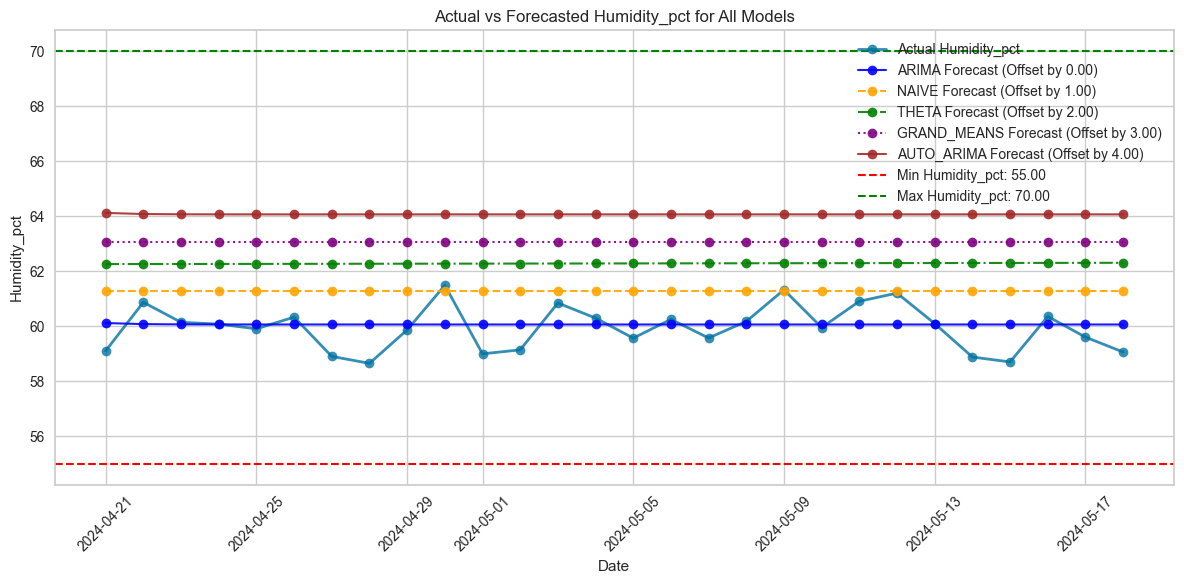

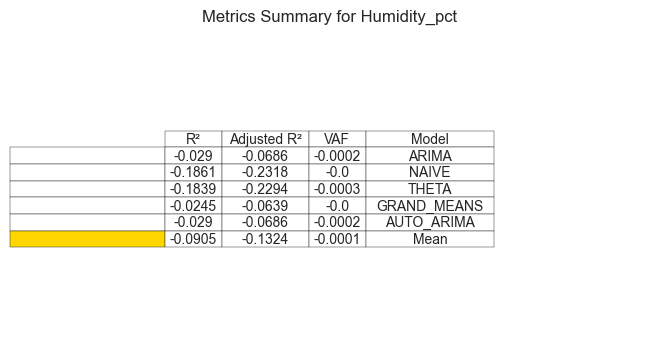

In [ ]:
filePath = 'weather_data.csv'
temperatureForecasts = runForecastPipeline(
    filePath, 
    'Temperature_C', 
    minValue=10, 
    maxValue=25, 
    lineSpace=1, 
)

humidityForecasts = runForecastPipeline(
    filePath, 
    'Humidity_pct', 
    minValue=55, 
    maxValue=70, 
    lineSpace=1
)
